# Södermanland	
# Sthlm

![My Image](./Map-of-Sweden-showing-the-21-administrative-regions-adapted-from-SCB-2007.png)


In [1]:
#importing modules
from math import *
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas
from scipy.interpolate import interp1d

# 1. DATA preprocessing

In [2]:
#Parameters
n=20
startvecka=10-4 #start week
Tmax=48 #length of prediction
pv=0.023 #fraction of infected that are admitted

rho=7*1/5.1 #latency period
gamma=7*1/5 #recovery rate

delay=3#2.5 #delay from infection to admission

In [3]:
file = pandas.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx',sheet_name="Inskrivna i slutenvård")
data = [['Sthlm', 8,2389923], ['VGR', 9,1725881], ['Skåne', 10,1387650],['Östergötland',11,467095],['Jönköping',12,364750],['Södermanland',13,299101],['Uppsala',14,387628],['Gävleborg',15,287660],['Västmanland',16,277074],['Örebro',17,305726],['Norrbotten',18,249768],['Dalarna',19,287806],['Västernorrland',20,244855],['Värmland',21,282840],['Halland',22,336132],['Kalmar',23,245992],['Kronoberg',24,202163],['Västerbotten',25,273061],['Jämtland',26,130972],['Blekinge',27,159349],['Gotland',28,60106]] 
regioner = pandas.DataFrame(data, columns = ['region', 'index','population']) 
regionkod=['SE-AB','SE-O','SE-M','SE-E','SE-F','SE-D','SE-C','SE-X','SE-U','SE-T','SE-BD','SE-W','SE-Y','SE-S','SE-N','SE-H','SE-G','SE-AC','SE-Z','SE-K','SE-I']
regioner['Regionkod'] = regionkod
yta=np.array([6524,23800,10968,10559,8190,10437,5427,8504,6075,28029,18118,17519,5118,54665,97239,11165,21549,8424,2931,48935,3135]) #area of region
regioner['Area']=yta
ffall = 9*np.ones(21).astype(int) #week number when first case was recorded
regioner['Första fall'] = ffall
startvecka = ffall - 3

regioner.drop(regioner.index[[20]],inplace=True) #remove Gotland


In [4]:
print(startvecka)
regioner

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


,region,index,population,Regionkod,Area,Första fall
0,Sthlm,8,2389923,SE-AB,6524,9
1,VGR,9,1725881,SE-O,23800,9
2,Skåne,10,1387650,SE-M,10968,9
3,Östergötland,11,467095,SE-E,10559,9
4,Jönköping,12,364750,SE-F,8190,9
5,Södermanland,13,299101,SE-D,10437,9
6,Uppsala,14,387628,SE-C,5427,9
7,Gävleborg,15,287660,SE-X,8504,9
8,Västmanland,16,277074,SE-U,6075,9
9,Örebro,17,305726,SE-T,28029,9


In [5]:
regioner['density'] = regioner['population']/regioner['Area']

In [6]:
file

,"Nyinskrivna i slutenvård med covid-19, antal patienter per inskrivningsvecka och region",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88
0,Antal unika patienter som rapporterats till So...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Totalt antal inskrivna patienter,NaN,Månadsrapportering till patientregistret,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,vecka 10,NaN,vecka 11,NaN,vecka 12,NaN,vecka 13,...,vecka 48,NaN,vecka 49,NaN,vecka 50,NaN,vecka 51,NaN,vecka 52,NaN
5,NaN,Antal,%*,Antal,%**,Antal,%**,Antal,%**,Antal,...,Antal,%**,Antal,%**,Antal,%**,Antal,%**,Antal,%**
6,Totalt inrapporterat,35057,100,63,0.179707,169,0.482072,639,1.822746,1465,...,1667,4.755113,1568,4.472716,1608,4.586816,1251,3.568474,365,1.041162
7,Rapporterande region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Stockholm,13035,37.182303,37,0.283851,83,0.636747,335,2.570004,734,...,632,4.848485,548,4.204066,521,3.996931,347,2.662064,43,0.329881
9,Västra Götaland,5293,15.098269,9,0.170036,18,0.340072,56,1.058001,94,...,205,3.87304,259,4.893255,323,6.102399,328,6.196864,202,3.816361


In [7]:
from scipy.interpolate import interp1d

def getData(namn,ffall):
    temp=regioner.loc[regioner['region']==namn] #find the right row
    index=temp['index'].values #find the region index
    N=temp['population'].values #find population size of region
    N = int(N[0])
    R = file.iloc[index[0]] 
    R=R.replace(' ','X') #replace missing data with 0
    R=R.replace('X',0) 
    R=R.replace('IU',0) 
    
    ind = np.arange(3,len(R),2) 
    I = R.iloc[ind].values #extract admissions
    #print(I)
    #print(len(I))
    I=I[:-2] #remove last (incomplete) data point
    #print(I)
    padding = np.zeros(10-ffall+3) 
    I=np.insert(I,0,padding) 
    #print(I)
    veckor = np.arange(0,len(I),1) #create array of week numbers
    #print(veckor)
    
    return I,veckor,N


#Load Google mobility data
def loadMobility(namn,svecka):
    df = pandas.read_csv('../data/2020_SE_Region_Mobility_Report.csv') 
    temp=regioner.loc[regioner['region']==namn] 
    kod=temp['Regionkod'].values 
    temp2=df.loc[df['iso_3166_2_code']==kod[0]]
    transit=temp2['transit_stations_percent_change_from_baseline'].values 
    dagar=np.arange(46,46+len(transit))
    tv=np.ceil(dagar/7)
    
    
    gveckor=np.unique(tv)
    k=0
    Tr=np.zeros(int(max(gveckor)-min(gveckor))+1)

    for i in gveckor:
        ind=tv==i
        Tr[k]=np.mean(transit[ind])/100
        k=k+1
    for i in range(1,len(Tr)):
        if np.isnan(Tr[i]):
            Tr[i]=Tr[i-1]
    #print(Tr)
    init=0.2 #set base line travel
    Tr[0:2]=[init,init]
    #print(Tr)
    #print(gveckor)
    #print(gveckor-svecka)
    Trfkn = interp1d(gveckor-svecka,Tr,kind="linear",fill_value="extrapolate")
    #print(Tr)
    return Trfkn

In [8]:
def loadMobility_list(namn_list, svecka):
    
    Trfkn_dict = dict()
    for i in namn_list:
       Trfkn_dict[i] = loadMobility(i,svecka) 

    return Trfkn_dict


def getData_list(namn_list, ffall):
    
    getData_dict = dict()
    for i in namn_list:
        I,veckor,N = getData(i,ffall)
        getData_dict[i] =  {'I':I,'veckor':veckor, 'N':N}

    return getData_dict

# 2. Correlation Analysis

In [9]:
namn_list = regioner.region.tolist()
Trfkn_dict = loadMobility_list(namn_list, svecka=6) 
getData_dict = getData_list(namn_list, ffall = 9) 

In [10]:
region_name = ['Sthlm']
df = pd.DataFrame(getData_dict['Sthlm']['I'])/regioner[regioner.region =='Sthlm'].density.values

for j in getData_dict.keys():
    if j == 'Sthlm':
        continue
    region_name.append(j)
    df_temp = pd.DataFrame(getData_dict[j]['I'])
  
    df_temp = df_temp/regioner[regioner.region ==j].density.values
    df = pd.concat([df,df_temp], axis = 1)
 

In [11]:
df.columns = region_name
df.head()

,Sthlm,VGR,Skåne,Östergötland,Jönköping,Södermanland,Uppsala,Gävleborg,Västmanland,Örebro,Norrbotten,Dalarna,Västernorrland,Värmland,Halland,Kalmar,Kronoberg,Västerbotten,Jämtland,Blekinge
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.101002,0.124111,0.0,0.0,0.0,0.0,0.056002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_Sthlm = pd.DataFrame(df.corr().loc['Sthlm']).sort_values(by = 'Sthlm', ascending=False)
df_Sthlm

,Sthlm
Sthlm,1.000000
Östergötland,0.968330
Dalarna,0.942713
Västmanland,0.919852
Norrbotten,0.916373
Södermanland,0.912002
Jönköping,0.911792
Uppsala,0.906437
Gävleborg,0.851443
Kalmar,0.845498


In [13]:
df_Skåne= pd.DataFrame(df.corr().loc['Skåne']).sort_values(by = 'Skåne', ascending=False)
df_Skåne

,Skåne
Skåne,1.000000
Kronoberg,0.895035
VGR,0.887548
Västmanland,0.844795
Kalmar,0.837116
Uppsala,0.836551
Södermanland,0.826470
Västernorrland,0.825453
Gävleborg,0.770706
Jämtland,0.714445


In [14]:
df_Uppsala= pd.DataFrame(df.corr().loc['Uppsala']).sort_values(by = 'Uppsala', ascending=False)
df_Uppsala

,Uppsala
Uppsala,1.000000
Västmanland,0.951433
Södermanland,0.935397
Kalmar,0.910907
Sthlm,0.906437
VGR,0.903484
Västernorrland,0.879517
Östergötland,0.836592
Skåne,0.836551
Gävleborg,0.834167


# 3. Modeling

## 3.1 Modeling wihout interactons

In [15]:

#time-dependent infectivity
def beta(t,a,b,transit_fkn):
    return a+b*transit_fkn(t)
#the RHS of the SEIR-model
#S=x1
#E=x2
#I=x3
#R=x4
def dx(x,t,a,b,lag):
    x1, x2, x3, x4= x[0], x[1], x[2], x[3]
    
    dx1 =  -x1*beta(t-lag,a,b,transit_fkn)*x3/N
    dx2 = x1*beta(t-lag,a,b,transit_fkn)*x3/N - rho*x2
    dx3 = rho*x2 - gamma*x3
    dx4 = gamma*x3
    
    return [dx1, dx2, dx3, dx4]

In [16]:
#define output from model
def pred_inlagda(t,a,b):
    x0 = [N-1,0,1,0] #initial conditions
    x = odeint(dx, x0, t,args=(a,b,delay))
    return pv*x[:,2]

            region  index  population Regionkod   Area  Första fall
0            Sthlm      8     2389923     SE-AB   6524            9
1              VGR      9     1725881      SE-O  23800            9
2            Skåne     10     1387650      SE-M  10968            9
3     Östergötland     11      467095      SE-E  10559            9
4        Jönköping     12      364750      SE-F   8190            9
5     Södermanland     13      299101      SE-D  10437            9
6          Uppsala     14      387628      SE-C   5427            9
7        Gävleborg     15      287660      SE-X   8504            9
8      Västmanland     16      277074      SE-U   6075            9
9           Örebro     17      305726      SE-T  28029            9
10      Norrbotten     18      249768     SE-BD  18118            9
11         Dalarna     19      287806      SE-W  17519            9
12  Västernorrland     20      244855      SE-Y   5118            9
13        Värmland     21      282840      SE-S 

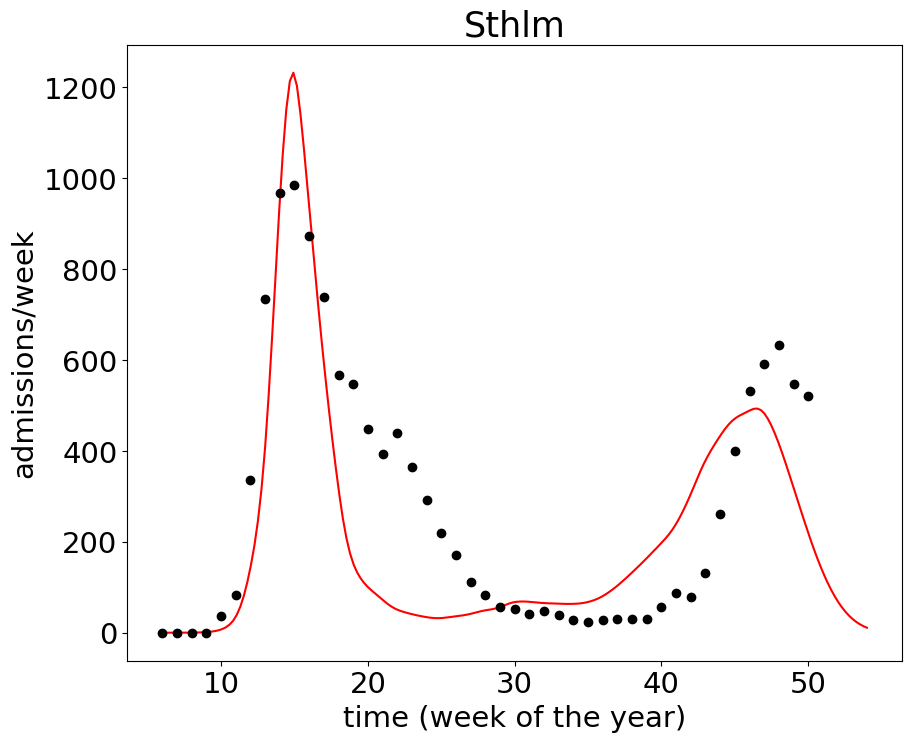

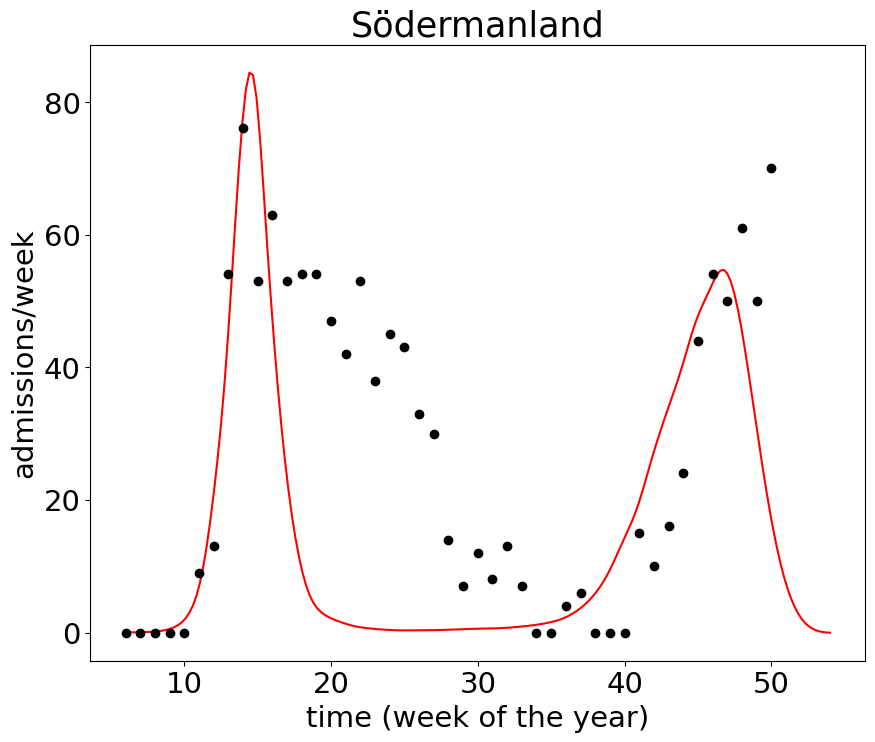

In [22]:
file = pandas.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx',sheet_name="Inskrivna i slutenvård")
data = [['Sthlm', 8,2389923], ['VGR', 9,1725881], ['Skåne', 10,1387650],['Östergötland',11,467095],['Jönköping',12,364750],['Södermanland',13,299101],['Uppsala',14,387628],['Gävleborg',15,287660],['Västmanland',16,277074],['Örebro',17,305726],['Norrbotten',18,249768],['Dalarna',19,287806],['Västernorrland',20,244855],['Värmland',21,282840],['Halland',22,336132],['Kalmar',23,245992],['Kronoberg',24,202163],['Västerbotten',25,273061],['Jämtland',26,130972],['Blekinge',27,159349],['Gotland',28,60106]] 
regioner = pandas.DataFrame(data, columns = ['region', 'index','population']) 
regionkod=['SE-AB','SE-O','SE-M','SE-E','SE-F','SE-D','SE-C','SE-X','SE-U','SE-T','SE-BD','SE-W','SE-Y','SE-S','SE-N','SE-H','SE-G','SE-AC','SE-Z','SE-K','SE-I']
regioner['Regionkod'] = regionkod
yta=np.array([6524,23800,10968,10559,8190,10437,5427,8504,6075,28029,18118,17519,5118,54665,97239,11165,21549,8424,2931,48935,3135]) #area of region
regioner['Area']=yta
ffall = 9*np.ones(21).astype(int) #week number when first case was recorded
regioner['Första fall'] = ffall 
startvecka = ffall - 3

regioner.drop(regioner.index[[20]],inplace=True) #remove Gotland
print(regioner)

namn = regioner['region'].values

t=np.linspace(0,Tmax,200)

regs = pandas.read_pickle('../data/param_IC.pkl') #load initial guesses for a and b for each region
astart = regs['a'].values
bstart = regs['b'].values

A=np.array([])
B=np.array([])
E=np.array([])

#Loop over regions
k=0
E = dict()
namn = ['Sthlm','Södermanland']
for R in namn:
    print(R)
    I,veckor,N = getData(R,ffall[k])
    transit_fkn=loadMobility(R,startvecka[k])
    #a,b,e = fitModel(veckor,I,astart[k],bstart[k])
    if R == 'Sthlm':
        print(1)
        pred = pred_inlagda(t,a = 4.738643629884578 ,b = 8.941339903151977)
    if R == 'Södermanland':
        pred = pred_inlagda(t,a = 3.51321353491882 ,b = 8.31602766854372)
    
    
    #Plot and save figure
    fig, axes = plt.subplots(1,1,figsize=(10,8))
    axes.plot(t+startvecka[k],pred,'r',label="Prediktion med resor") 
    axes.plot(veckor+startvecka[k],I,'ko',label="Inlagda")
    axes.set_xlabel('time (week of the year)')
    axes.set_ylabel('admissions/week')
    axes.set_title(R)
    #fig.savefig(R+".pdf",format='pdf')
    k=k+1
    
    #E[R]=np.sqrt(np.sum((pred-I)**2)/len(I))/np.amax(I)

## 3.2 Modeling with interactions

#### S[Sthlm]=x1      

#### E[Sthlm]=x2       

#### I[Sthlm]=x3       

#### R[Sthlm]=x4

#### S[Södermanland]=x5      

#### E[Södermanland]=x6       

#### I[Södermanland]=x7       

#### R[Södermanland]=x8

In [326]:
namn_list = ['Sthlm','Södermanland']
transit_fkn_dct = loadMobility_list(namn_list, svecka=6) 
getData_dict = getData_list(namn_list, ffall = 9) 
region_1 = namn_list[0]
region_2 = namn_list[1] 

def beta_1(t,a,b,transit_fkn):
    return a+b*transit_fkn(t)

def beta_2(t,a,b,transit_fkn):
    return a+b*transit_fkn(t)

def dx(x,t,a1,b1, a2, b2, c, lag):
    x1, x2, x3, x4, x5, x6, x7, x8 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]
    
    dx1_sthlm =  -x1 * beta_1(t-lag,a1,b1,transit_fkn_dct[region_1])*x3/getData_dict[region_1]['N'] 
    dx1_söd =  -x5 * beta_2(t-lag,a2,b2,transit_fkn_dct[region_2])*x7/getData_dict[region_2]['N'] 
    
    dx2_sthlm = x1 * beta_1(t-lag,a1,b1,transit_fkn_dct[region_1])*x3/getData_dict[region_1]['N'] - rho*x2
    dx2_söd = x5 * beta_2(t-lag,a2,b2,transit_fkn_dct[region_2])*x3/getData_dict[region_2]['N'] - rho*x6
    
    dx3_sthlm  = rho*x2 - gamma*x3
    dx3_söd = rho*x6 - gamma*x7
    
    dx4_sthlm  = gamma*x3
    dx4_söd = gamma*x7
    
    m = [dx1_sthlm, dx2_sthlm, dx3_sthlm, dx4_sthlm, dx1_söd, dx2_söd, dx3_söd, dx4_söd]

    return m     

def pred_inlagda(t,a1,b1, a2, b2, c,lag):
    N_region_1 = getData_dict[region_1]['N']
    N_region_2 = getData_dict[region_2]['N']
    
    x0 = [N_region_1-1,0,1,0, N_region_2-1,0,1,0] #initial conditions
 

    x = odeint(dx, x0, t,args=(a1,b1, a2, b2, c,lag))

    return pv*x[:,2], pv*x[:,6]

In [327]:

pred_inlagda(veckor_train, 4.759494, 9.215190, 3.51321353491882,	8.31602766854372, 0.0 ,delay)

(array([2.30000000e-02, 5.82266957e-02, 2.94716036e-01, 1.49527251e+00,
        7.58446349e+00, 3.84191937e+01, 1.58137001e+02, 4.50633843e+02,
        1.04222299e+03, 1.30982210e+03, 9.51174006e+02, 5.64275201e+02,
        2.77124216e+02, 1.20055115e+02, 7.28221468e+01, 4.95075462e+01,
        3.26018069e+01, 2.49558430e+01, 1.99946055e+01, 1.81012577e+01,
        1.97320895e+01, 2.21142204e+01, 2.56105549e+01, 2.86504418e+01,
        3.35299068e+01, 3.28841721e+01, 3.05686966e+01, 2.90526601e+01,
        2.81015737e+01, 2.92451991e+01, 3.42582359e+01, 4.35852148e+01,
        5.53325278e+01, 6.80201048e+01, 8.14659781e+01, 9.85813482e+01,
        1.26467767e+02, 1.58694750e+02, 1.83630880e+02, 2.03019991e+02,
        2.14933786e+02, 2.17327800e+02, 1.90017829e+02, 1.47044228e+02,
        1.00886962e+02]),
 array([2.30000000e-02, 4.68746920e-02, 2.31351980e-01, 1.17215796e+00,
        5.94075576e+00, 2.99800363e+01, 1.23038208e+02, 3.31812791e+02,
        6.73649466e+02, 7.51540149e+02

In [328]:
I_train_sthlm

array([0.0, 0.0, 0.0, 0.0, 37, 83, 335, 734, 968, 984, 872, 739, 567, 548,
       448, 394, 440, 364, 292, 220, 171, 111, 82, 57, 52, 41, 47, 38, 28,
       23, 29, 30, 31, 31, 57, 88, 78, 131, 262, 399, 531, 592, 632, 548,
       521], dtype=object)

In [329]:
I_train_Södermanland

array([0.0, 0.0, 0.0, 0.0, 0, 9, 13, 54, 76, 53, 63, 53, 54, 54, 47, 42,
       53, 38, 45, 43, 33, 30, 14, 7, 12, 8, 13, 7, 0, 0, 4, 6, 0, 0, 0,
       15, 10, 16, 24, 44, 54, 50, 61, 50, 70], dtype=object)

In [351]:
namn_list = ['Sthlm','Södermanland']
transit_fkn_dct = loadMobility_list(namn_list, svecka=6) 
getData_dict = getData_list(namn_list, ffall = 9) 
region_1 = namn_list[0]
region_2 = namn_list[1] 

def beta_1(t,a,b,transit_fkn):
    return a+b*transit_fkn(t)

def beta_2(t,a,b,transit_fkn):
    return a+b*transit_fkn(t)

def dx(x,t,a1,b1, a2, b2, c, lag):
    x1, x2, x3, x4, x5, x6, x7, x8 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]
    
    dx1_sthlm =  -x1 * (beta_1(t-lag,a1,b1,transit_fkn_dct[region_1])*x3/getData_dict[region_1]['N']  + c* x7/getData_dict[region_2]['N'])
    dx1_söd =  -x5 * (beta_2(t-lag,a2,b2,transit_fkn_dct[region_2])*x7/getData_dict[region_2]['N'] + c* x3/getData_dict[region_1]['N'])
    
    dx2_sthlm = x1 * (beta_1(t-lag,a1,b1,transit_fkn_dct[region_1])*x3/getData_dict[region_1]['N']  + c* x7/getData_dict[region_2]['N'])- rho*x2
    dx2_söd = x5 * (beta_2(t-lag,a2,b2,transit_fkn_dct[region_2])*x3/getData_dict[region_2]['N'] + c* x3/getData_dict[region_1]['N']) - rho*x6
    
    dx3_sthlm  = rho*x2 - gamma*x3
    dx3_söd = rho*x6 - gamma*x7
    
    dx4_sthlm  = gamma*x3
    dx4_söd = gamma*x7
    
    m = [dx1_sthlm, dx2_sthlm, dx3_sthlm, dx4_sthlm, dx1_söd, dx2_söd, dx3_söd, dx4_söd]

    return m     
    

def pred_inlagda(t,a1,b1, a2, b2, c,lag):
    N_region_1 = getData_dict[region_1]['N']
    N_region_2 = getData_dict[region_2]['N']
    
    x0 = [N_region_1-1,0,1,0, N_region_2-1,0,1,0] #initial conditions
 

    x = odeint(dx, x0, t,args=(a1,b1, a2, b2, c,lag))

    return pv*x[:,2], pv*x[:,6]

In [352]:
x0

[2389922, 0, 1, 0, 299100, 0, 1, 0]

In [367]:
namn_list = ['Sthlm','Södermanland']
transit_fkn_dct = loadMobility_list(namn_list, svecka=6) 
getData_dict = getData_list(namn_list, ffall = 9) 
region_1 = namn_list[0]
region_2 = namn_list[1] 

I_train_sthlm = getData_dict['Sthlm']['I']
I_train_Södermanland= getData_dict['Södermanland']['I']
veckor_train = getData_dict['Södermanland']['veckor']  # getData_dict['Södermanland']['veckor'] == getData_dict['Sthlm']['veckor']

n=10
ah_sthlm = np.linspace(3,10,n)
bh_sthlm = np.linspace(4,10,n)

ah_söd = np.linspace(3,10,n)
bh_söd = np.linspace(4,10,n)


c = np.linspace(0,0.5,n)

E_sthlm = np.zeros((len(ah_sthlm),len(bh_sthlm),len(ah_söd),len(bh_söd)))
E_söd = np.zeros((len(ah_sthlm),len(bh_sthlm),len(ah_söd),len(bh_söd)))

In [368]:
4.759494,9.215190
P = pred_inlagda(veckor_train, ah_sthlm[0], bh_sthlm[0], ah_söd[0], bh_söd[0], 0.1 ,delay)
c

array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ])

In [355]:
t=np.linspace(0,Tmax,200)
len(t)

200

In [356]:
P = pred_inlagda(t, 4.759494, 9.215190, 3.51321353491882,	8.31602766854372, 0. ,delay)

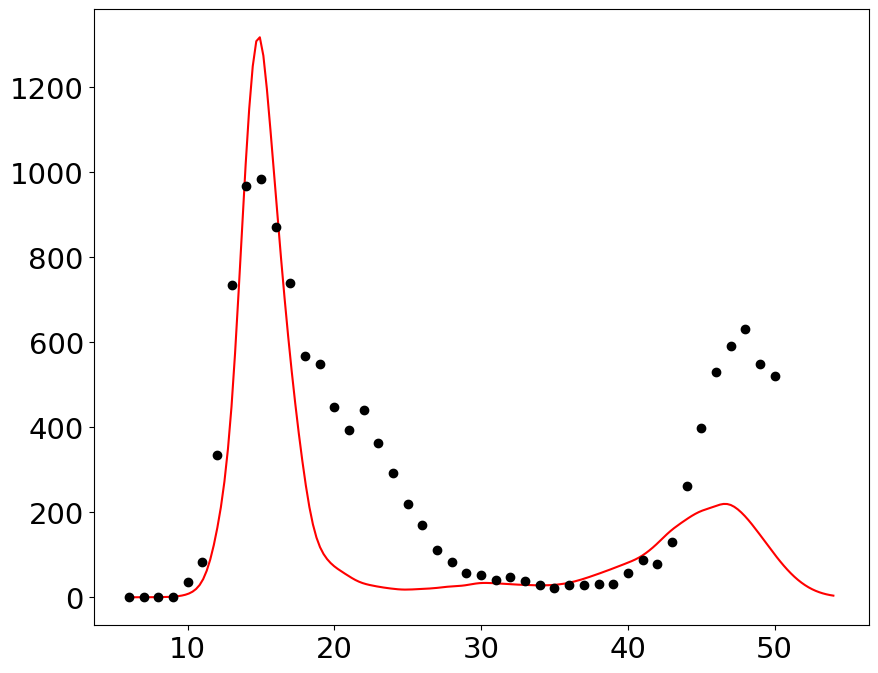

In [357]:
fig, axes = plt.subplots(1,1,figsize=(10,8))
axes.plot(t+6,P[0],'r',label="Prediktion med resor") 
axes.plot(veckor+ 6,I_train_sthlm,'ko',label="Inlagda")

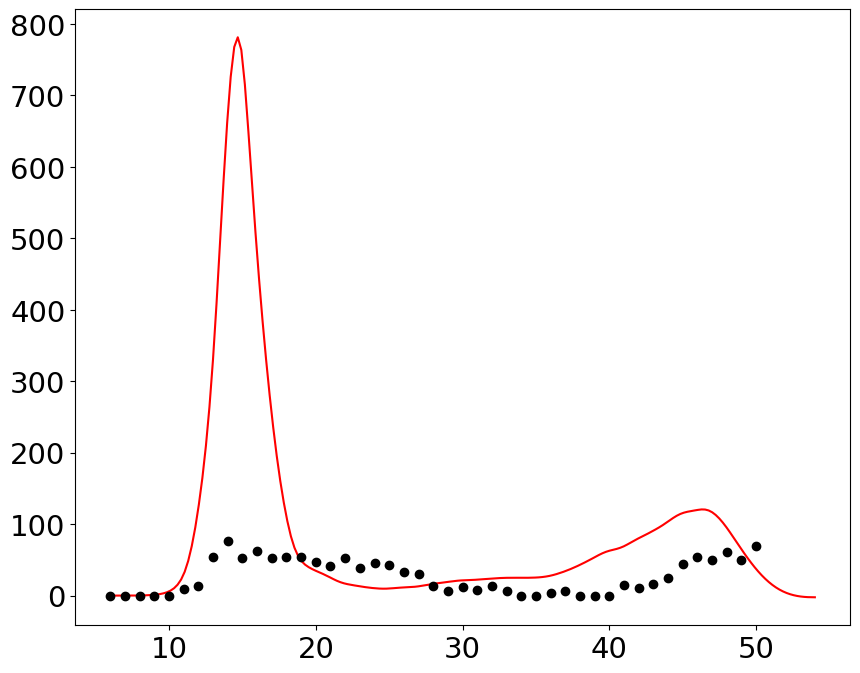

In [358]:
fig, axes = plt.subplots(1,1,figsize=(10,8))
axes.plot(t+6,P[1],'r',label="Prediktion med resor") 
axes.plot(veckor+ 6,I_train_Södermanland,'ko',label="Inlagda")

In [359]:
startvecka

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [360]:
I_train_sthlm 

array([0.0, 0.0, 0.0, 0.0, 37, 83, 335, 734, 968, 984, 872, 739, 567, 548,
       448, 394, 440, 364, 292, 220, 171, 111, 82, 57, 52, 41, 47, 38, 28,
       23, 29, 30, 31, 31, 57, 88, 78, 131, 262, 399, 531, 592, 632, 548,
       521], dtype=object)

In [361]:
I_train_Södermanland

array([0.0, 0.0, 0.0, 0.0, 0, 9, 13, 54, 76, 53, 63, 53, 54, 54, 47, 42,
       53, 38, 45, 43, 33, 30, 14, 7, 12, 8, 13, 7, 0, 0, 4, 6, 0, 0, 0,
       15, 10, 16, 24, 44, 54, 50, 61, 50, 70], dtype=object)

# Well Well Well, negative counts, something wrong in the code

In [ ]:
from tqdm import tqdm
for i in tqdm(range(n)):
    for j in range(n):
        for k in range(n):
            for l in range(n): 
                for m in range(n):
                    P_sthlm, P_söd = pred_inlagda(veckor_train, ah_sthlm[i], bh_sthlm[j], ah_söd[k], bh_söd[l], c[m], delay)
                    RMSE_sthlm = np.sqrt(np.sum((P_sthlm-I_train_sthlm)**2)/len(veckor_train))
                    RMSE_söd = np.sqrt(np.sum((P_söd-I_train_Södermanland)**2)/len(veckor_train))
                    E_sthlm[i,j,k,l] = RMSE_sthlm
                    E_söd[i,j,k,l] = RMSE_söd                 

  0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?it/s]/root/miniconda3/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [247]:
P_sthlm

array([ 2.30000000e-02,  3.02158148e-01,  4.36811079e+00,  6.39384692e+01,
        9.00692303e+02,  8.24445853e+03,  1.53642922e+04,  9.04270152e+03,
        3.67083028e+03,  1.28261347e+03,  4.14546740e+02,  1.27852455e+02,
        3.82335686e+01,  1.11891384e+01,  3.22382313e+00,  9.18032488e-01,
        2.59058973e-01,  7.25890548e-02,  2.02256291e-02,  5.61026138e-03,
        1.55071813e-03,  4.27394845e-04,  1.17517531e-04,  3.22481553e-05,
        8.83501758e-06,  2.41693326e-06,  6.60326067e-07,  1.80185451e-07,
        4.90958431e-08,  1.33979812e-08,  3.64683153e-09,  9.61874138e-10,
        2.78721266e-10,  7.89349763e-11,  2.25834523e-11, -8.07972993e-13,
       -1.13822271e-11, -9.03795749e-12, -9.62525515e-12, -5.68916145e-12,
       -3.84292138e-12, -2.10339902e-12, -1.30839883e-12, -1.25310662e-12,
       -1.19781441e-12])

In [248]:
I_train_sthlm

array([0.0, 0.0, 0.0, 0.0, 37, 83, 335, 734, 968, 984, 872, 739, 567, 548,
       448, 394, 440, 364, 292, 220, 171, 111, 82, 57, 52, 41, 47, 38, 28,
       23, 29, 30, 31, 31, 57, 88, 78, 131, 262, 399, 531, 592, 632, 548,
       521], dtype=object)

In [249]:
P_söd

array([ 2.30000000e-02,  1.00751600e-01,  1.51024305e+00,  2.20901179e+01,
        3.10450757e+02,  2.77361925e+03,  4.82384832e+03,  2.73765716e+03,
        1.09433319e+03,  3.78882481e+02,  1.21585050e+02,  3.72605448e+01,
        1.10736292e+01,  3.22065130e+00,  9.22353009e-01,  2.61095475e-01,
        7.32353212e-02,  2.03992081e-02,  5.65058282e-03,  1.55863707e-03,
        4.28692417e-04,  1.17633270e-04,  3.22282596e-05,  8.81849791e-06,
        2.41035672e-06,  6.58064970e-07,  1.79527849e-07,  4.89522635e-08,
        1.33375093e-08,  3.64186168e-09,  9.92435430e-10,  2.62345984e-10,
        7.61976131e-11,  2.16277794e-11,  6.20467987e-12, -2.09133174e-13,
       -3.11178456e-12, -2.47639745e-12, -2.64002651e-12, -1.56277411e-12,
       -1.05843935e-12, -5.80690446e-13, -3.62279839e-13, -3.46971514e-13,
       -3.31663189e-13])

In [365]:
optind = np.where(E_söd == np.amin(E_söd))
afiE_söd = ah[optind[0]]
bfitE_söd  = bh[optind[1]]

print("Minimum RMSE: ",E_söd[optind])
#print("a=",afiE_sthlm,"b=",bfit)

Minimum RMSE:  [23.36866798]


In [ ]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]

print("Minimum RMSE: ",E_sthlm[optind])
#print("a=",afiE_sthlm,"b=",bfit)

In [ ]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]


In [76]:
regs = pandas.read_pickle('../data/param_IC.pkl') #load initial guesses for a and b for each region
astart = regs['a'].values
bstart = regs['b'].values

In [77]:
regs

,region,index,population,Regionkod,a,b,E
0,Sthlm,8,2389923,SE-AB,4.759494,9.215190,175.235300
1,VGR,9,1725881,SE-O,3.848101,9.493671,90.821751
2,Skåne,10,1387650,SE-M,3.620253,8.240506,41.357155
3,Östergötland,11,467095,SE-E,3.734177,8.379747,17.383155
4,Jönköping,12,364750,SE-F,3.278481,10.050633,21.330193
5,Södermanland,13,299101,SE-D,3.734177,9.215190,15.531288
6,Uppsala,14,387628,SE-C,3.506329,6.430380,17.883654
7,Gävleborg,15,287660,SE-X,3.164557,10.746835,20.700678
8,Västmanland,16,277074,SE-U,3.506329,6.848101,8.616789
9,Örebro,17,305726,SE-T,3.392405,8.379747,12.290108
